In [24]:
%load_ext autoreload
%autoreload 2

from lib.ekyn import *
import matplotlib.pyplot as plt
from lib.models import MLP
from torch.utils.data import DataLoader,ConcatDataset
from lib.deep_learning_utils import count_params
import torch
import os
from lib.env import DATA_PATH
from sklearn.model_selection import train_test_split

if not os.path.isdir(f'{DATA_PATH}/projects'):
    os.makedirs(f'{DATA_PATH}/projects')

existing_projects = sorted([int(dir) for dir in os.listdir(f'{DATA_PATH}/projects')])
if len(existing_projects) == 0:
    PROJECT_ID = 0
else:
    PROJECT_ID = existing_projects[-1] + 1

PROJECT_PATH = f'{DATA_PATH}/projects/{PROJECT_ID}'
if not os.path.isdir(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)

CONFIG = {
    'BATCH_SIZE':2048,
    'TRAIN_IDS':[],
    'TEST_IDS':[]
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
ids = get_ekyn_ids()
conditions = ['Vehicle','PF']

In [26]:
CONFIG['TRAIN_IDS'],CONFIG['TEST_IDS'] = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)

trainloader = DataLoader(
    dataset=ConcatDataset(
    [EpochedDataset(id=id,condition=condition) for id in CONFIG['TRAIN_IDS'] for condition in conditions]
    ),
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True
)
devloader = DataLoader(
    dataset=ConcatDataset(
    [EpochedDataset(id=id,condition=condition) for id in CONFIG['TEST_IDS'] for condition in conditions]
    ),
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False
)
print(len(trainloader)*CONFIG['BATCH_SIZE'])
print(len(devloader)*CONFIG['BATCH_SIZE'])

208896
69632


In [41]:
from lib.models import ResidualBlock
from torch import nn
class Frodo(nn.Module):
    """
    the little wanderer
    """
    def __init__(self,n_features) -> None:
        super().__init__()
        self.n_features = n_features
        self.block1 = ResidualBlock(1,8,n_features)
        self.block2 = ResidualBlock(8,16,n_features)
        self.block3 = ResidualBlock(16,16,n_features)

        self.gap = nn.AvgPool1d(kernel_size=n_features)
        self.fc1 = nn.Linear(in_features=16,out_features=3)
    def forward(self,x,classification=True):
        x = x.view(-1,1,self.n_features)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        if(classification):
            x = self.fc1(x.squeeze())
            return x
        else:
            return x.squeeze()
model = Frodo(n_features=1000)
model.cuda()
model = torch.compile(model)
torch.set_float32_matmul_precision('high')
print(f'{count_params(model)} parameters')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

8187 parameters


In [42]:
lossi = []
trainlossi = []
trainf1 = []
devlossi = []
devf1 = []
model.train()
from tqdm import tqdm
from lib.deep_learning_utils import training_loop,development_loop
for i in tqdm(range(1000)):
    loss,f1 = training_loop(model=model,trainloader=trainloader,criterion=criterion,optimizer=optimizer,device='cuda')
    trainlossi.append(loss)
    trainf1.append(f1)

    loss,f1 = development_loop(model=model,devloader=devloader,criterion=criterion,device='cuda')
    devlossi.append(loss)
    devf1.append(f1)
    scheduler.step(loss)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,4),dpi=200)
    ax[0].plot(trainlossi)
    ax[0].plot(devlossi)
    ax[0].set_title(label='loss',fontweight='bold')
    ax[0].set_xlabel('Epoch')
    ax[1].plot(trainf1)
    ax[1].plot(devf1)
    ax[1].set_title(label='f1',fontweight='bold')
    ax[1].set_xlabel('Epoch')

    plt.savefig('loss.jpg')
    plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 178/1000 [14:52<1:08:41,  5.01s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),f'{PROJECT_PATH}/model.last.pt')

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:00<00:00, 68.92it/s]


              precision    recall  f1-score   support

         0.0       0.57      0.63      0.60      3504
         1.0       0.94      0.91      0.92     31617
         2.0       0.89      0.91      0.90     33999

    accuracy                           0.89     69120
   macro avg       0.80      0.81      0.81     69120
weighted avg       0.89      0.89      0.89     69120

0.27874743741224794


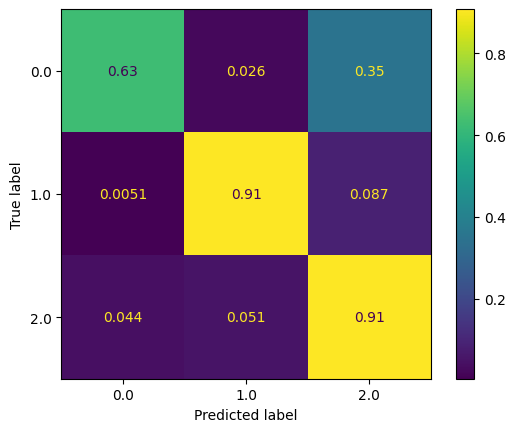

In [44]:
from lib.deep_learning_utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
plt.savefig(f'{PROJECT_PATH}/cm.jpg')
print(classification_report(y_true,y_pred))
print(loss)